# Kathmandu Training with ResNet18

Breakdown into three sections, Image read in and analysis, meteorology read in and analysis, and combination of both.


First, we work with our images.

In [1]:
# from __future__ import print_function, division


import numpy as np
np.random.seed(42)
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
import math
import pandas as pd
from datetime import datetime, timedelta
from os import listdir
from os.path import isfile, join
import glob
import pickle as pkl
import random
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
import torchvision.models as models
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, TensorDataset, Dataset
import time
from joblib import dump, load

from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, RandomTreesEmbedding
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

use_gpu = torch.cuda.is_available()
if use_gpu:
    print('Using CUDA')
from tqdm import tqdm 


# Where to save the figures
PROJECT_ROOT_DIR = "."
PROJECT_SAVE_DIR = "Figure_PDFs"

import os
if not (os.path.isdir(PROJECT_ROOT_DIR+'/'+PROJECT_SAVE_DIR)):
    print('Figure directory didn''t exist, creating now.')
    os.mkdir(PROJECT_ROOT_DIR+'/'+PROJECT_SAVE_DIR)
else:
    print('Figure directory exists.') 

# Define a function to save future figures to PDFs
def savepdf(fig,name):
    fig.savefig(PROJECT_ROOT_DIR+'/'+PROJECT_SAVE_DIR+'/'+name+'.png')
    
import statistics


np.random.seed(2020)
torch.manual_seed(2020)
torch.cuda.manual_seed(2020)
torch.cuda.manual_seed_all(2020)
torch.backends.cudnn.deterministic = True

Using CUDA
Figure directory exists.


##### Define plotting functions

In [2]:
from scipy import stats
from sklearn import metrics


# To evaluate the statistics between predicted and true PM2.5
def eval_stat(y_train_pred, y_train):
    Rsquared = stats.spearmanr(y_train_pred, y_train.ravel())[0]
    pvalue = stats.spearmanr(y_train_pred, y_train.ravel())[1]
    Rsquared_pearson = stats.pearsonr(y_train_pred, y_train.ravel())[0]
    pvalue_pearson = stats.pearsonr(y_train_pred, y_train.ravel())[1]
    return Rsquared, pvalue, Rsquared_pearson, pvalue_pearson

# To plot the predicted and true PM2.5 along with the calculated statistics
def plot_result(y_train_pred, y_train, Rsquared, pvalue, Rsquared_pearson, pvalue_pearson, plot_label="train", lower_bound=0, upper_bound=175,
                save = True, fig_name = '', lr = '', batch_size=''):
    plt.rcParams.update({'mathtext.default':  'regular' })
    my_prediction = y_train_pred
    fig, ax = plt.subplots(figsize = (10,10))
#     plt.ylim([0,max(y_train_pred)])
    ax.scatter(y_train, my_prediction,color = 'green', edgecolors=(0, 0, 0),  s = 100)
    ax.plot([lower_bound, upper_bound], [lower_bound, upper_bound], 'k--', lw=4)
    ax.set_xlabel('True $PM_{2.5}$ ($\mu $g m$^{-3}$)', size = 20)
    ax.set_ylabel('Predicted $PM_{2.5}$ ($\mu $g m$^{-3}$)', size = 20)
    ax.tick_params(labelsize = 10)
    fig.text(0.15, 0.8, 'Spearman r = '+ str(round(Rsquared,2)),bbox=dict(facecolor="black", alpha=0.5) ,color='white', weight='roman', 
    fontsize=20)
    fig.text(0.15, 0.76, 'Spearman p-value = '+ str(round(pvalue,2)), bbox=dict(facecolor='black', alpha = 0.5),color='white', weight='roman', 
    fontsize=20)
    plt.axis('tight')
    fig.text(0.15, 0.72, 'Pearson r = '+ str(round(Rsquared_pearson,2)), bbox=dict(facecolor='black', alpha = 0.5),color='white', weight='roman', 
    fontsize=20)
    fig.text(0.15, 0.68, 'Pearson p-value = '+ str(round(pvalue_pearson,3)),bbox=dict(facecolor='black', alpha = 0.5),color='white', weight='roman', 
    fontsize=20)
    fig.text(0.15, 0.64, 'RMSE = '+ str(round(np.sqrt(metrics.mean_squared_error(y_train, my_prediction)),2)), 
    bbox=dict(facecolor='black', alpha = 0.5),color='white', weight='roman', fontsize=20)
    fig.text(0.15, 0.60, 'MAE = '+ str(round(metrics.mean_absolute_error(y_train, my_prediction),2)), 
    bbox=dict(facecolor='black', alpha = 0.5),color='white', weight='roman', fontsize=20)
    fig.text(0.15, 0.56, '% error = '+ str(round(metrics.mean_absolute_error(y_train, my_prediction)/np.mean(y_train)*100,1))+'%', 
    bbox=dict(facecolor='black', alpha = 0.5),color='white', weight='roman', fontsize=20)
    
#     fig.text(0.6,0.30, 'LR='+ lr, bbox=dict(facecolor='Green', alpha= 0.5), color='white', weight='roman', fontsize=18)
#     fig.text(0.6,0.26, 'batch = '+ batch_size, bbox=dict(facecolor='Green', alpha= 0.5), color='white', weight='roman', fontsize=18)

    if plot_label == "train":
        fig.text(0.615, 0.8, 'training dataset', bbox=dict(facecolor='grey', alpha=0.9),color='black', weight='roman',
        fontsize=20)
    else:
        fig.text(0.615, 0.8, 'test dataset', bbox=dict(facecolor='grey', alpha=0.9),color='black', weight='roman',
        fontsize=20)
        
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()
    if save:
        savepdf(fig,fig_name)
    pass
    return


#for plotting results
def train_test_loss(loss_train, loss_test, epochs, save = True, fig_name=''):
    fig    = plt.plot(figsize=(16, 16))
    ax     = plt.gca()
    epoch = range(epochs)
#     ax.set_yscale('log')
    ax.plot(epoch, loss_train, color='b', linewidth=0.5, label='Train loss')
    ax.plot(epoch, loss_test, color='r', linewidth=0.5, label='Test loss')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title('Train and (log) test loss of predicting ground-level PM2.5')
    ax.legend()
    plt.show()
    
    if save:
        savepdf(fig, fig_name)

# Run RandomForest

In [10]:
met = []
pm = []
with open('/datacommons/carlsonlab/srs108/old/ol/Kathmandu.pkl', 'rb') as fp:
    for station in tqdm(pkl.load(fp), position=0, leave=True):
        print(station)
#         for data_point in station:
#             print(data_point['Meteo'])
#             met.append(data_point['Meteo'].values)
#             pm.append(data_point['PM'])


 14%|█▍        | 1/7 [00:02<00:13,  2.18s/it]

[{'Image': array([[[244, 244, 233, 255],
        [240, 240, 229, 255],
        [242, 241, 230, 255],
        ...,
        [254, 255, 249, 255],
        [254, 255, 249, 255],
        [254, 255, 249, 255]],

       [[244, 244, 232, 255],
        [241, 240, 229, 255],
        [239, 239, 227, 255],
        ...,
        [254, 255, 249, 255],
        [254, 255, 249, 255],
        [255, 255, 249, 255]],

       [[243, 243, 231, 255],
        [241, 241, 228, 255],
        [236, 236, 224, 255],
        ...,
        [254, 255, 249, 255],
        [254, 255, 249, 255],
        [254, 255, 248, 255]],

       ...,

       [[179, 186, 180, 255],
        [181, 187, 181, 255],
        [180, 186, 180, 255],
        ...,
        [255, 255, 249, 255],
        [255, 255, 249, 255],
        [255, 255, 250, 255]],

       [[181, 187, 182, 255],
        [183, 188, 183, 255],
        [182, 188, 183, 255],
        ...,
        [255, 255, 247, 255],
        [255, 255, 248, 255],
        [255, 255, 249, 255]],

 

 29%|██▊       | 2/7 [00:04<00:10,  2.19s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 43%|████▎     | 3/7 [00:05<00:07,  1.92s/it]

[{'Image': array([[[147, 128, 111, 255],
        [141, 122, 107, 255],
        [145, 125, 108, 255],
        ...,
        [197, 177, 156, 255],
        [179, 162, 141, 255],
        [164, 148, 125, 255]],

       [[145, 126, 109, 255],
        [140, 122, 105, 255],
        [136, 118, 101, 255],
        ...,
        [195, 175, 154, 255],
        [185, 167, 145, 255],
        [161, 147, 124, 255]],

       [[151, 134, 113, 255],
        [141, 125, 105, 255],
        [135, 120, 100, 255],
        ...,
        [180, 163, 141, 255],
        [176, 160, 139, 255],
        [163, 150, 128, 255]],

       ...,

       [[171, 151, 131, 255],
        [163, 144, 125, 255],
        [152, 135, 116, 255],
        ...,
        [124, 115,  96, 255],
        [136, 125, 105, 255],
        [142, 130, 109, 255]],

       [[168, 147, 128, 255],
        [162, 143, 123, 255],
        [158, 139, 120, 255],
        ...,
        [142, 130, 109, 255],
        [142, 131, 108, 255],
        [141, 129, 107, 255]],

 

 57%|█████▋    | 4/7 [00:06<00:04,  1.46s/it]

[{'Image': array([[[192, 173, 156, 255],
        [165, 150, 131, 255],
        [135, 126, 107, 255],
        ...,
        [162, 149, 134, 255],
        [152, 140, 125, 255],
        [135, 127, 113, 255]],

       [[172, 157, 138, 255],
        [156, 144, 123, 255],
        [149, 138, 116, 255],
        ...,
        [173, 157, 145, 255],
        [162, 148, 135, 255],
        [148, 137, 122, 255]],

       [[164, 150, 132, 255],
        [163, 151, 131, 255],
        [169, 156, 135, 255],
        ...,
        [151, 138, 126, 255],
        [156, 142, 129, 255],
        [159, 145, 130, 255]],

       ...,

       [[172, 159, 141, 255],
        [168, 156, 138, 255],
        [174, 160, 141, 255],
        ...,
        [162, 142, 128, 255],
        [163, 144, 129, 255],
        [156, 139, 123, 255]],

       [[179, 163, 145, 255],
        [177, 162, 145, 255],
        [179, 165, 147, 255],
        ...,
        [160, 141, 126, 255],
        [159, 141, 126, 255],
        [156, 140, 125, 255]],

 

 71%|███████▏  | 5/7 [00:06<00:02,  1.11s/it]

[{'Image': array([[[191, 171, 152, 255],
        [177, 160, 140, 255],
        [168, 153, 134, 255],
        ...,
        [156, 141, 123, 255],
        [139, 128, 113, 255],
        [134, 125, 107, 255]],

       [[204, 183, 165, 255],
        [194, 174, 157, 255],
        [180, 162, 144, 255],
        ...,
        [150, 137, 119, 255],
        [139, 128, 111, 255],
        [143, 130, 112, 255]],

       [[208, 186, 169, 255],
        [199, 178, 161, 255],
        [182, 164, 146, 255],
        ...,
        [167, 150, 133, 255],
        [173, 155, 139, 255],
        [178, 160, 142, 255]],

       ...,

       [[183, 167, 151, 255],
        [179, 163, 147, 255],
        [176, 159, 143, 255],
        ...,
        [183, 167, 149, 255],
        [172, 158, 140, 255],
        [176, 162, 143, 255]],

       [[184, 167, 149, 255],
        [189, 170, 154, 255],
        [191, 172, 155, 255],
        ...,
        [173, 158, 140, 255],
        [170, 156, 137, 255],
        [182, 167, 148, 255]],

 

 86%|████████▌ | 6/7 [00:06<00:00,  1.16it/s]

[{'Image': array([[[145, 133, 119, 255],
        [149, 138, 125, 255],
        [135, 127, 114, 255],
        ...,
        [196, 180, 164, 255],
        [201, 184, 167, 255],
        [203, 185, 165, 255]],

       [[151, 139, 124, 255],
        [153, 141, 126, 255],
        [147, 135, 120, 255],
        ...,
        [193, 179, 165, 255],
        [195, 180, 162, 255],
        [200, 183, 163, 255]],

       [[141, 132, 116, 255],
        [145, 133, 118, 255],
        [146, 134, 117, 255],
        ...,
        [198, 182, 166, 255],
        [197, 181, 164, 255],
        [198, 181, 162, 255]],

       ...,

       [[199, 181, 161, 255],
        [206, 187, 168, 255],
        [205, 187, 167, 255],
        ...,
        [172, 159, 140, 255],
        [165, 154, 137, 255],
        [159, 149, 131, 255]],

       [[201, 184, 163, 255],
        [218, 198, 179, 255],
        [216, 196, 177, 255],
        ...,
        [185, 171, 152, 255],
        [181, 167, 149, 255],
        [177, 164, 144, 255]],

 

100%|██████████| 7/7 [00:07<00:00,  1.02s/it]

[{'Image': array([[[189, 164, 134, 255],
        [178, 156, 124, 255],
        [192, 166, 132, 255],
        ...,
        [135, 116,  90, 255],
        [130, 112,  86, 255],
        [119, 103,  78, 255]],

       [[171, 150, 117, 255],
        [188, 162, 126, 255],
        [205, 176, 144, 255],
        ...,
        [148, 127, 100, 255],
        [131, 113,  88, 255],
        [107,  92,  71, 255]],

       [[154, 136, 106, 255],
        [178, 153, 119, 255],
        [193, 166, 135, 255],
        ...,
        [158, 136, 111, 255],
        [129, 112,  90, 255],
        [123, 105,  85, 255]],

       ...,

       [[138, 120,  98, 255],
        [147, 128, 103, 255],
        [130, 115,  85, 255],
        ...,
        [145, 120,  93, 255],
        [137, 114,  89, 255],
        [136, 114,  88, 255]],

       [[129, 113,  90, 255],
        [139, 122,  92, 255],
        [138, 120,  87, 255],
        ...,
        [142, 120,  90, 255],
        [133, 113,  86, 255],
        [144, 121,  92, 255]],

 

In [6]:
met[1]

array([57.7   ,  3.3   ,  4.1   , 58.    , 54.    ,  1.0111])

In [7]:
embed_model = RandomTreesEmbedding(n_estimators=100, max_depth=2)
embed_model.fit(met)
dump(embed_model, '/datacommons/carlsonlab/srs108/embed_model.joblib')

['/datacommons/carlsonlab/srs108/embed_model.joblib']

# Combined Met and Image dataset

In [8]:
class Comb_Met_Image(Dataset):
    def __init__(self, txt_directory, mode = 'train', train_split = 0):
        if mode not in ['train', 'test']:
            raise Exception('Mode must be \'train\' or \'test\'!')
            
        
        self.train_split = train_split
        self.mode = mode
        
        #variables used within class only
        self.train_images, self.test_images= [], []        
        self.pm_test ,self.pm_train, self.pm= [], [], []
        self.met, self.met_train, self.met_test = [], [], []
        
        with open(txt_directory, "rb") as fp:
            for station in tqdm(pkl.load(fp), position=0, leave=True):
                for data_point in station:
                    self.train_images.append(data_point['Image'][:,:,:3])
                    self.met.append(data_point['Meteo'].values)
                    self.pm.append(data_point['PM'])
                    
        embed_model = load('/datacommons/carlsonlab/srs108/embed_model.joblib')
        self.embed_fit_trans = embed_model.transform(self.met).toarray()
        self.met_size = self.embed_fit_trans.shape[1]
        
        if self.train_split  != 0:
            split_idx         = int(np.ceil(self.embed_fit_trans.shape[0] * self.train_split))
            
            self.met_test = self.embed_fit_trans[split_idx:]
            self.met_train = self.embed_fit_trans[:split_idx]
           
            self.pm_test = self.pm[split_idx:]
            self.pm_train = self.pm[:split_idx]
            
            self.test_images  =  self.train_images[split_idx:]            
            self.train_images =  self.train_images[:split_idx]
            
            
#             self.met_train = np.array(self.met_train)
#             self.met_test = np.array(self.met_test)
#             self.pm_train = np.array(self.pm_train)
#             self.test_pm = np.array(self.pm_test)
            
        rf_model = RandomForestRegressor(n_estimators= 8, max_depth = 30)
        rf_model.fit(self.met_train, self.pm_train)
        self.predictions_train, self.predictions_test = [], []
        self.predictions_train = rf_model.predict(self.met_train)
        self.predictions_test = rf_model.predict(self.met_test)
        
        if mode == 'train':
            del self.test_images, self.pm_test
        else:
            del self.train_images, self.pm_train
        
        
        
    def __len__(self):
        if self.mode == 'train':
            return len(self.pm_train)
        else:
            return len(self.pm_test)
        
        
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        #performing transformations on images no prereq needed. We just transform allof them for now  
        if self.mode == 'train':
            sat_img = self.train_images[idx]
            sat_img = sat_img.astype(np.uint8)
            transform  = transforms.Compose([
                                transforms.ToPILImage(),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(degrees=30),
                                transforms.CenterCrop(size=224),
                                transforms.ToTensor()])

            sat_img = transform(sat_img)
            pred_rf_pm = self.predictions_train[idx]
#             print(self.predictions_train)
            meteo =  self.embed_fit_trans[idx]
            value = self.pm_train[idx]
#             print(sat_img, meteo, value)
            
        elif self.mode == 'test':
            sat_img = self.test_images[idx] 
            sat_img = sat_img.astype(np.uint8)
            transform = transforms.Compose([
                                transforms.ToPILImage(),
                                transforms.CenterCrop(size=224),
                                transforms.ToTensor()])

            sat_img=transform(sat_img)   
            pred_rf_pm = self.predictions_test[idx]
            meteo =  self.embed_fit_trans[idx]
            value = self.pm_test[idx]
#             print(sat_img, meteo, value)
            
        return sat_img, meteo, value


In [10]:
training_dataset = Comb_Met_Image('/datacommons/carlsonlab/srs108/pkls/Kathmandu.pkl', mode ='train', train_split = 0.8)
testing_dataset = Comb_Met_Image('/datacommons/carlsonlab/srs108/pkls/Kathmandu.pkl', mode ='test', train_split = 0.8)

100%|██████████| 7/7 [00:00<00:00, 698.49it/s]


### Extracting true PM values for testing and training

In [11]:
true_PM_train = []
true_PM_test  = []

for i in range(0,len(training_dataset)):
    true_PM_train.append(training_dataset[i][2])
    
for j in range(0, len(testing_dataset)):
    true_PM_test.append(testing_dataset[j][2])
    
    
true_PM_train = np.array(true_PM_train)
true_PM_test  = np.array(true_PM_test)

In [12]:
print(len(true_PM_train))
print(len(true_PM_test))

3881
970


### PyTorch DataLoaders

In [13]:
#shuffle (bool, optional) – set to True to have the data reshuffled at every epoch (default: False).

batch_size        = 64
trainloader       = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
trainloader_final = DataLoader(training_dataset, batch_size=batch_size, shuffle=False)
testloader        = DataLoader(testing_dataset, batch_size=batch_size, shuffle=False)

## Defining Transfer Learning Network (ResNet18)

In [1]:
# # Define CNN + dropout + FC pipeline
class build_model(nn.Module):
    def __init__(self, transformed_meteo_size):
        super(build_model, self).__init__()
        
        # Load the pretrained weights on ImageNet
        resnet18 = models.resnet18(pretrained=True)
        
        
        ###but we’ll train only the very last few fully-connected layers. Initially, we freeze all of the model’s weights:
        
#         # Freeze all feature extraction layers in the encoder
#         for param in resnet18.parameters():
#             param.requires_grad = True
        
        # Model initialization
        self.resnet_pretrained = resnet18
        self.transformed_meteo_size = transformed_meteo_size
        self.fc1 = nn.Linear(self.resnet_pretrained.fc.out_features + transformed_meteo_size, 256)
        self.dropout = nn.Dropout(p=0.2)
        self.elu = nn.ELU()
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 1)
    
    
    def forward(self, image, transformed_meteo_features):
        img_features = self.resnet_pretrained(image)
        img_features = torch.flatten(img_features, 1)
#         print(img_features.shape)
#         print(transformed_meteo_features.shape)
        x = torch.cat((img_features, transformed_meteo_features), dim =-1)
#         print(self.resnet_pretrained.fc.out_features + self.transformed_meteo_size)
        
        x = self.fc1(x.float())
        

        
        x = self.elu(x)
        x = self.dropout(x)
        x = self.fc2(x.float())
        x = self.elu(x)
        x = self.fc3(x)
    
        return x.float()
#     print(img_features, transformed_meteo_features)

## Set up training and testing functions

NameError: name 'nn' is not defined

`model.train()` vs. `model.eval()`


`model.train()`: tells model you are training; layers such as dropout, batchnorm behave differently in this train than they do in eval. Model has to learn the layers.

`model.eval()`: indicates nothing new is to be learned, and the model is used for testing only. 

In [22]:
def train(model, device, trainloader, criterion, optimizer, epoch):     
    training_loss = []
    running_loss  = 0
    model.train()
    y_train_pred  = torch.empty(0).to(device)
    for images, met, labels in tqdm(trainloader):
        images, met, labels = images.to(device), met.to(device), labels.to(device) #, rf_pred.to(device)
        optimizer.zero_grad()
        output         = torch.squeeze(model(images, met), dim=1)
        loss           = criterion(labels.float(), output)
        loss.backward()
        optimizer.step()
        y_train_pred   = torch.cat((y_train_pred, output))

        running_loss  += loss.item() * images.size(0)
        
    print("Epoch: {}... ".format(epoch),
    "Train MSE loss: {:.4f}".format(running_loss/len(trainloader.dataset)))

    training_loss.append(running_loss/len(trainloader.dataset))
#         testing_loss.append(test_loss/len(testloader.dataset))
#     print(y_train_pred, rf_pred)    
    return y_train_pred, training_loss


def test(model, device, testloader, criterion):
    model.eval()
    test_loss = 0
    ypred     = torch.empty(0).to(device)

    with torch.no_grad():
        for images, met, labels in tqdm(testloader):
            images, met, labels = images.to(device), met.to(device), labels.to(device) #, rf_pred.to(device)
            output         = torch.squeeze(model(images,met), dim=1)
            test_loss     += criterion(labels, output).item() * images.size(0)
            ypred          = torch.cat((ypred, output))
            
    test_loss /= len(testloader.dataset)
    
    print('Test set: Loss: {:.4f}'.format(test_loss))
#     print(ypred, rf_pred)
    return ypred, test_loss

## Define Main Function

In [23]:
def main(early_stopping_thres = -1):
    epochs              = 75
    lr                  = 1e-6
    model               = build_model(training_dataset.met_size)
    smallest_test_loss  = 1e6
    early_stopping_count = 0
    current_epoch = 50
    torch.manual_seed(1)
    criterion           = nn.MSELoss()
    optimizer           = torch.optim.Adam(model.parameters(), lr = lr)
    device              = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model               = model.to(device)
    print('Training Begins')
    
    y_train_pred_final, y_test_pred_final = torch.empty(0), torch.empty(0)
    loss_train_arr, loss_test_arr = [], []  
    
    for epoch in range(1, epochs + 1):
        
        train(model, device, trainloader, criterion, optimizer, epoch)
        y_train_pred, training_loss = test(model, device, trainloader_final, criterion)
        y_test_pred, loss_test      = test(model, device, testloader, criterion)
        loss_train_arr.append(training_loss)
        loss_test_arr.append(loss_test)
        
        
        if loss_test < smallest_test_loss:
            early_stopping_count = 0
            smallest_test_loss = loss_test + 0
            y_train_pred_final = copy.copy(y_train_pred)
            y_test_pred_final = copy.copy(y_test_pred)
        
        else:
            early_stopping_count += 1
            if early_stopping_count > early_stopping_thres:
                current_epoch = epoch
                print('Early stopping criterion reached. Exiting...', loss_test)
                print(early_stopping_count, early_stopping_thres)
                break
        
    return y_train_pred_final, y_test_pred_final, loss_train_arr, loss_test_arr, current_epoch

In [24]:
nonshuffled_PM25_train_pred, nonshuffled_PM25_test_pred, nonshuffled_loss_train, nonshuffled_loss_test, current_epoch = main(early_stopping_thres=8)

  0%|          | 0/61 [00:00<?, ?it/s]

Training Begins


  0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 1...  Train MSE loss: 4156.6005


  5%|▍         | 3/61 [00:12<04:00,  4.14s/it]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-24-51e9a3241362>", line 1, in <module>
    nonshuffled_PM25_train_pred, nonshuffled_PM25_test_pred, nonshuffled_loss_train, nonshuffled_loss_test, current_epoch = main(early_stopping_thres=8)
  File "<ipython-input-23-c61136859a9c>", line 21, in main
    y_train_pred, training_loss = test(model, device, trainloader_final, criterion)
  File "<ipython-input-22-9c1de4a842ee>", line 34, in test
    output         = torch.squeeze(model(images,met), dim=1)
  File "/hpc/home/srs108/.local/lib/python3.7/site-packages/torch/nn/modules/module.py", line 1110, in _call_impl
    return forward_call(*input, **kwargs)
  File "<ipython-input-18-f7dcf65b83dd>", line 27, in forward
    img_features = self.resnet_pretrained(image)
  File "/hpc/home/srs108/.local/lib/python3.7/site-packages/t

TypeError: object of type 'NoneType' has no len()

In [20]:
current_epoch

50

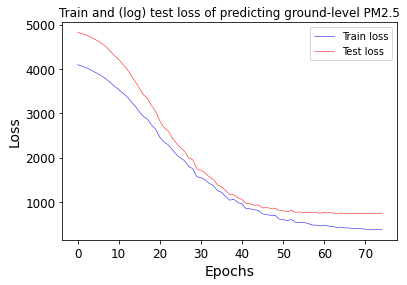

In [21]:
train_test_loss(nonshuffled_loss_train, nonshuffled_loss_test, epochs = 75, save=False, fig_name='losses')


In [22]:
#Get predictied values for plotting
predicted_PM_train = nonshuffled_PM25_train_pred.cpu().detach()
predicted_PM_train = np.array(predicted_PM_train)
predicted_PM_test = nonshuffled_PM25_test_pred.cpu().detach()
predicted_PM_test = np.array(predicted_PM_test) 

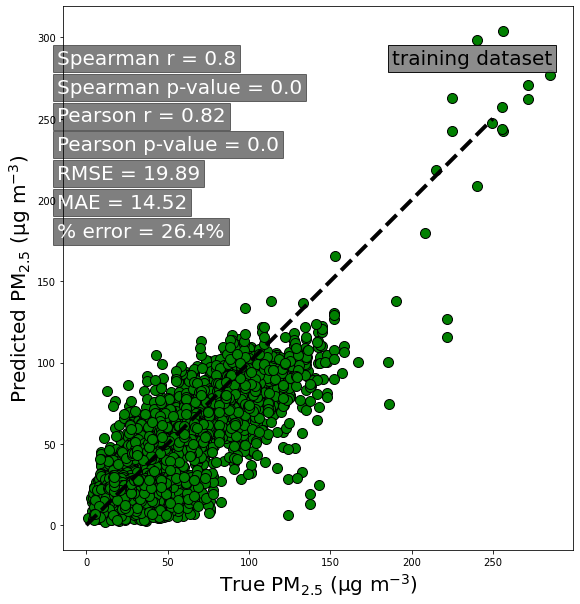

In [23]:
Rsquared, pvalue, Rsquared_pearson, pvalue_pearson = eval_stat(predicted_PM_train, true_PM_train)
plot_result(predicted_PM_train, true_PM_train, Rsquared, pvalue, Rsquared_pearson, pvalue_pearson, 
            plot_label='train',  lower_bound= 0, upper_bound=250,save=False, fig_name = 'training_kath_224x224_w_met_aod_10am_only', 
           lr = '1e-4', batch_size = str(batch_size))

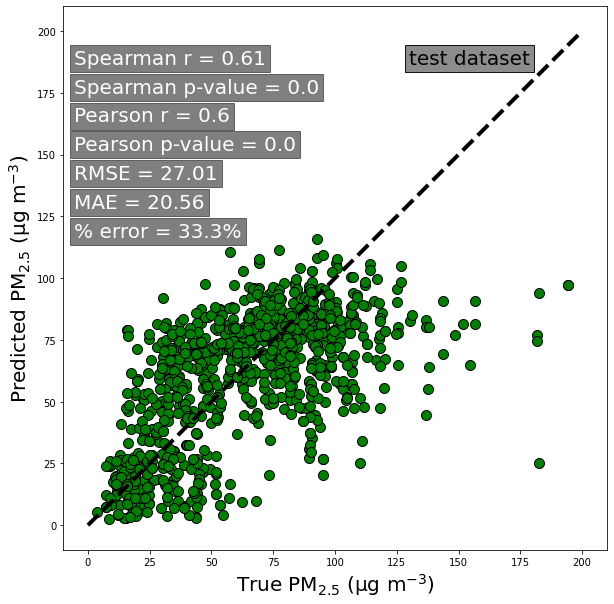

In [24]:
Rsquared, pvalue, Rsquared_pearson, pvalue_pearson = eval_stat(predicted_PM_test, true_PM_test)
plot_result(predicted_PM_test, true_PM_test, Rsquared, pvalue, Rsquared_pearson, pvalue_pearson, plot_label='test',
            lower_bound=0, upper_bound=200, save=False, fig_name='testing_kath_224x224m_w_met_aod_10am_only',
            lr = '1e-4', batch_size = str(batch_size))

In [33]:
met = []
pm = []
with open('/datacommons/carlsonlab/srs108/JOB/Delhi_labeled.pkl', 'rb') as fp:
    for station in tqdm(pkl.load(fp), position=0, leave=True):
        pm.append(tuple((station['Image'][:,:,:3], station['PM25'])))
#         for data_point in station:
#             pm.append(data_point)

100%|██████████| 31568/31568 [00:00<00:00, 456626.80it/s]


In [31]:
pm[0]
# plt.imshow(pm[0]['Image'])

{'Image': array([[[179, 173, 157],
         [180, 173, 158],
         [179, 172, 158],
         ...,
         [169, 166, 150],
         [175, 170, 154],
         [175, 170, 153]],
 
        [[176, 170, 155],
         [177, 171, 156],
         [180, 173, 157],
         ...,
         [168, 165, 149],
         [172, 168, 151],
         [170, 166, 149]],
 
        [[176, 170, 154],
         [178, 171, 155],
         [179, 172, 156],
         ...,
         [168, 165, 148],
         [168, 165, 148],
         [168, 164, 148]],
 
        ...,
 
        [[171, 170, 155],
         [169, 167, 153],
         [172, 169, 155],
         ...,
         [174, 168, 153],
         [181, 173, 157],
         [178, 172, 155]],
 
        [[169, 168, 153],
         [169, 167, 152],
         [171, 167, 152],
         ...,
         [177, 171, 155],
         [184, 176, 160],
         [178, 171, 155]],
 
        [[165, 164, 149],
         [169, 168, 153],
         [174, 170, 155],
         ...,
         [177, 171,

In [ ]:
for i in range(15):
    print('True PM: {}, Predicted PM: {}, iteration {}'.format(training))

### With shuffled trainloader

def main():
    epochs    = 25
    lr        = 0.0001
    model     = build_model()
    torch.manual_seed(1)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    device    = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model     = model.to(device)
    print('Training Begins')
    
    y_train_pred, y_test_pred     = torch.empty(0), torch.empty(0)
    loss_train_arr, loss_test_arr = [], []  
    
    for epoch in range(1, epochs + 1):
        train(model, device, trainloader, criterion, optimizer, epoch)
        y_train_pred, training_loss = test(model, device, trainloader, criterion)
        y_test_pred, loss_test      = test(model, device, testloader, criterion)
        loss_train_arr.append(training_loss)
        loss_test_arr.append(loss_test)
    return y_train_pred, y_test_pred, loss_train_arr, loss_test_arr

shuffled_PM25_train_pred, shuffled_PM25_test_pred, shuffled_loss_train, shuffled_loss_test = main()

Older code

 Plot the train and test loss over epochs
fig = plt.plot(figsize=(16, 16))
ax = plt.gca()
epochs = range(50)
ax.plot(epochs, loss_train, color='b', linewidth=0.5, label='Train loss')
ax.plot(epochs, loss_test, color='r', linewidth=0.5, label='Test loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_title('Train and test loss of predicting ground-level PM2.5')
ax.legend()

transfer_model = models.resnet18(pretrained=True)

from torchsummary import summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transfer_model = transfer_model.to(device) 

num_ftrs = transfer_model.fc.in_features

transfer_model.fc = nn.Linear(num_ftrs,1)

transfer_model = transfer_model.to(device)
criterion = nn.MSELoss()
print(criterion)
optimizer = torch.optim.SGD(transfer_model.parameters(), lr = 0.001)

test_loss = []
train_loss = []

ypred = []

def train_model(model, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        for images, labels in tqdm(train_dataloader):
            inputs = images.to(device)
            labels = labels.float().unsqueeze(1).to(device)
            
            optimizer.zero_grad() #zero gradients each epoch bc pytorch 
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            train_loss.append(loss.item())
            
            loss.backward()
            optimizer.step()
            
        test_model()
        transfer_model.train()
        
def test_model():
    
    correct = 0
    total = len(testing_dataset)
    transfer_model.eval()
    
    with torch.no_grad():
        for images, labels in tqdm(test_dataloader):
            inputs = images.to(device)
            labels = labels.unsqueeze(1).to(device)
            
            y = transfer_model(inputs)
            
            loss = criterion(y, labels)
            
            test_loss.append(loss.item())
            
            predictions = torch.round(torch.sigmoid(y)).long()
            correct += torch.sum((predictions == labels).float())
    print(predictions)


np.random.seed(99)
train_model(transfer_model, criterion, optimizer, num_epochs=10)

# model = build_model()
# criterion = nn.MSELoss
# optimizer = torch.optim.SGD(model.parameters(), lr = 0.001)
# epochs = 50

# training_loss, test_loss = main()


epochs = np.linspace(1,10,len(train_loss))
plt.figure(figsize=(7,7))
plt.plot(epochs, train_loss)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Training Loss with pretrained weights')
plt.show()

epochs = np.linspace(1,10,len(test_loss))
plt.figure(figsize=(7,7))
plt.plot(epochs, test_loss)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Testing Loss with pretrained weights')
plt.show()

In [ ]:
#Non shuffled, non normalized Dataset

class NonShuffled_NonNormalized_Dataset():
    
    def __init__(self, txt_directory, transform_on = 'train', 
                 train_split = 0):
        
        #variables definied in init
        self.transform_on = transform_on
        self.train_split = train_split
        
        #variables used within class only
        self.ground_PM, self.train_images, self.test_images ,self.grids= [], [], [], []

        if transform_on not in ['train', 'test']:
            raise Exception('Mode must be either \'train\', or \'test\'.')
            
        #extracting pm values and image arrays into their own lists.
        with open(txt_directory, 'rb') as f:
            while True:
                try:
                    self.grids.append(pkl.load(f))
                except EOFError:
                    break
        for i in tqdm(range(0, len(self.grids))):
            self.ground_PM.append(self.grids[i]['PM'])
            self.train_images.append(self.grids[i]['Image'][:, :, :3]) 
#         with open(txt_directory, "rb") as fp:
#             data = pkl.load(fp)
            
#             for i in range(0, len(data)):
#                 self.ground_PM.append(data[i]['PM'])
#                 self.train_images.append(data[i]['Image'][:, :, :3])  
                    #self.ground_PM = np.array(ground_PM)
        
        if self.train_split  != 0:
            split_idx         = int(np.ceil(len(self.train_images) * self.train_split))
            self.test_images  = self.train_images[split_idx:]            
            self.train_images = self.train_images[:split_idx]
            
    def __len__(self):
        if self.transform_on == 'train':
            return len(self.train_images)
        
        elif self.transform_on == "test":
            return len(self.test_images)
        
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        #performing transformations on images  
        if self.transform_on == 'train':
            sample = self.train_images[idx]
            transform  = transforms.Compose([
                                transforms.ToPILImage(),
                                transforms.CenterCrop(size=224),
                                transforms.ToTensor()])

            sample=transform(sample)
            
        elif self.transform_on == 'test':
            sample = self.test_images[idx]  
            transform = transforms.Compose([
                                transforms.ToPILImage(),
                                transforms.CenterCrop(size=224),
                                transforms.ToTensor()])

            sample=transform(sample)
        return sample, self.ground_PM[idx]

In [4]:

#IMGAE
class CNN_Dataset():
    
    def __init__(self, txt_directory, transform_on = 'train', 
                 train_split = 0):
        
        #variables definied in init
        self.transform_on = transform_on
        self.train_split = train_split
        
        #variables used within class only
        self.train_images, self.test_images ,self.grids, self.normal_PM= [], [], [], []
#         self.met, self.met_transformed = [], []
        self.paired_img_pm = []
        
        if transform_on not in ['train', 'test']:
            raise Exception('Mode must be either \'train\', or \'test\'.')
            
        #extracting pm values and image arrays into their own lists.
        with open(txt_directory, 'rb') as f:
            for station in tqdm(pkl.load(f), position=0, leave=True):
                for data_point in station:
                    self.grids.append(tuple((data_point['Image'], data_point['PM'])))
#                     self.met.append(data_point['Meteo'].values)
                    
        
#         self.met_transformed = rt_model.transform(self.met).toarray()
#                     if data_point:
#                     self.ground_PM.append(data_point['PM'])
#                     self.train_images.append(data_point['Image'])
#                 except EOFError:
#                     break
#         for i in tqdm(range(0, len(self.grids))):
#             self.ground_PM.append(self.grids[i][1])
#             self.train_images.append(self.grids[i][0][:, :, :3]) 
            
            
        #normalization of PM values, 0 mean
#         pm_mean = np.mean(self.ground_PM)
#         pm_std = np.std(self.ground_PM)
#         for i in self.ground_PM:
#             z = (i-pm_mean)/pm_std
#             self.normal_PM.append(z)
            
        #random shuffling of data
#         self.paired_img_pm = [[x, y] for x, y in zip(self.train_images, self.ground_PM)]
        random.shuffle(self.grids)
        
        if self.train_split  != 0:
            split_idx         = int(np.ceil(len( self.grids) * self.train_split))
            self.test_images  =  self.grids[split_idx:]            
            self.train_images =  self.grids[:split_idx]
            
    def __len__(self):
        if self.transform_on == 'train':
            return len(self.train_images)
        elif self.transform_on == "test":
            return len(self.test_images)
        
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        #performing transformations on images  
        if self.transform_on == 'train':
            sample = self.train_images[idx][0]
            sample = sample.astype(np.uint8)
            transform  = transforms.Compose([
                                transforms.ToPILImage(),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(degrees=30),
                                transforms.CenterCrop(size=224),
                                transforms.ToTensor()])

            sample=transform(sample)
            
        elif self.transform_on == 'test':
            sample = self.test_images[idx][0]  
            sample = sample.astype(np.uint8)
            transform = transforms.Compose([
                                transforms.ToPILImage(),
                                transforms.CenterCrop(size=224),
                                transforms.ToTensor()])

            sample=transform(sample)
            
#         data = [[x, y] for x, y in zip(sample, self.ground_PM)]

        return sample, self.grids[idx][1]

# Meteorology Dataset

In [32]:
class Met_Dataset():
    
    def __init__(self, txt_directory, transform_on = 'train', 
                 train_split = 0):
        
        #variables definied in init
        self.transform_on = transform_on
        self.train_split = train_split
        self.mode = transform_on
        #variables used within class only
        self.pm_test ,self.pm_train, self.pm= [], [], []
        self.met, self.met_transformed_train, self.met_transformed_test = [], [], []
#         self.paired_img_pm = []
        
        if transform_on not in ['train', 'test']:
            raise Exception('Mode must be either \'train\', or \'test\'.')
            
        #extracting pm values and image arrays into their own lists.
        with open(txt_directory, 'rb') as f:
            for station in tqdm(pkl.load(f), position=0, leave=True):
                for data_point in station:
                    self.met.append(data_point['Meteo'].values)
                    self.pm.append(data_point['PM'])
        
        
        self.met_transformed_train = rf_model.transform(self.met).toarray()
            
        #random shuffling of data
#         self.paired_img_pm = [[x, y] for x, y in zip(self.train_images, self.ground_PM)]
#         random.shuffle/(self.grids)
        
        if self.train_split  != 0:
            split_idx         = int(np.ceil(len(self.met) * self.train_split))
            self.met_transformed_test = self.met_transformed_train[split_idx:]
            self.met_transformed_train = self.met_transformed_train[:split_idx]
           
            self.pm_test = self.pm[split_idx:]
            self.pm_train = self.pm[:split_idx]
            
            
        if self.mode == 'train':
            del self.met_transformed_test, self.pm_test
        else:
            del self.met_transformed_train, self.pm_train
        del self.met    
        
    def __len__(self):
        if self.mode == 'train':
            return len(self.met_transformed_train)
        elif self.mode == "test":
            return len(self.met_transformed_test)
        
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        if self.mode == "train":
            return self.met_transformed_train[idx], self.pm_train[idx]
            
        if self.mode == "test":
            return self.met_transformed_test[idx], self.pm_test[idx]


In [7]:
# train_features, test_features, train_labels, test_labels = train_test_split(met, pm, test_size = 0.20, random_state = 42)